In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from keras import regularizers
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = "G:\mask\data\Train"
test_dir = "G:\mask\data\Test"
val_dir = "G:\mask\data\Validation"

In [3]:
batch_size = 32
target_size = (180, 180)

In [6]:
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,   
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'  
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'  
)

Found 2304 images belonging to 2 classes.
Found 768 images belonging to 2 classes.
Found 4481 images belonging to 2 classes.


In [7]:
def view_images(target_dir, target_class, num_images, rows, cols, target_size):
    target_folder = os.path.join(target_dir, target_class)
    all_images = os.listdir(target_folder)
    random_images = random.sample(all_images, num_images)

    plt.figure(figsize=(18, 10))

    for i, image_name in enumerate(random_images, start=1):
        img_path = os.path.join(target_folder, image_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (target_size, target_size))  # Resize to square

        plt.subplot(rows, cols, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
        plt.title(target_class)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

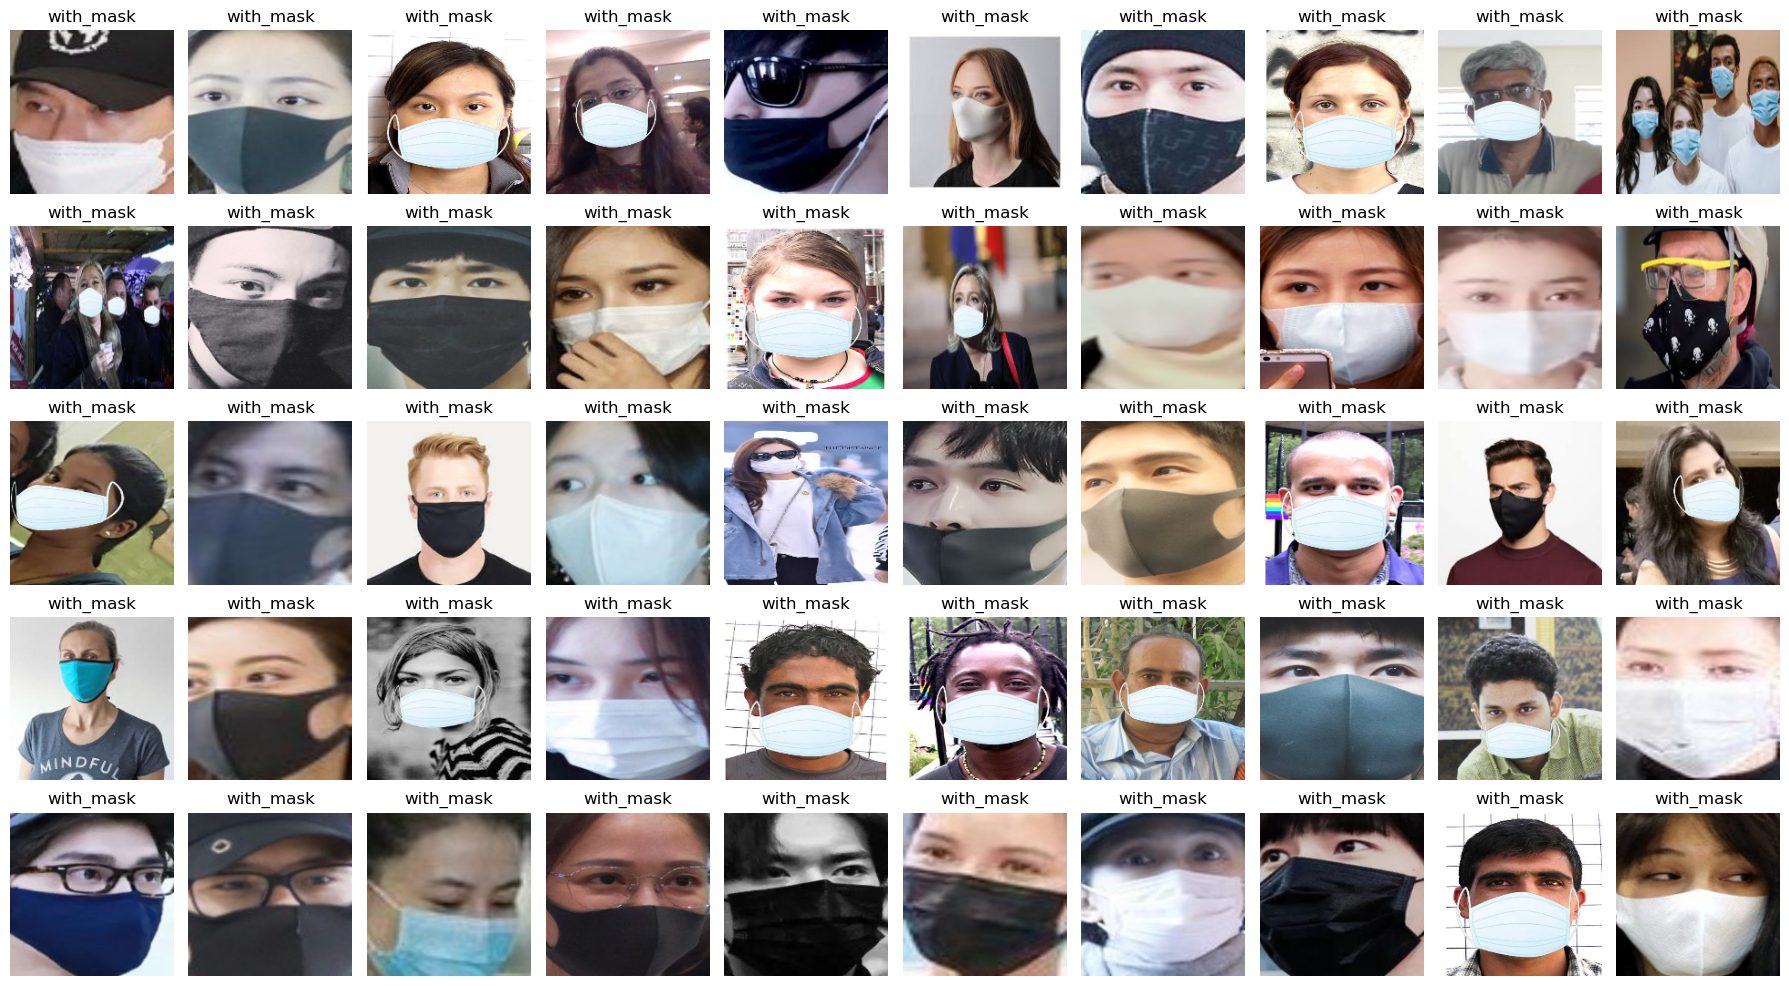

In [9]:
view_images(train_dir, "with_mask", num_images=50, rows=5, cols=10, target_size=180)

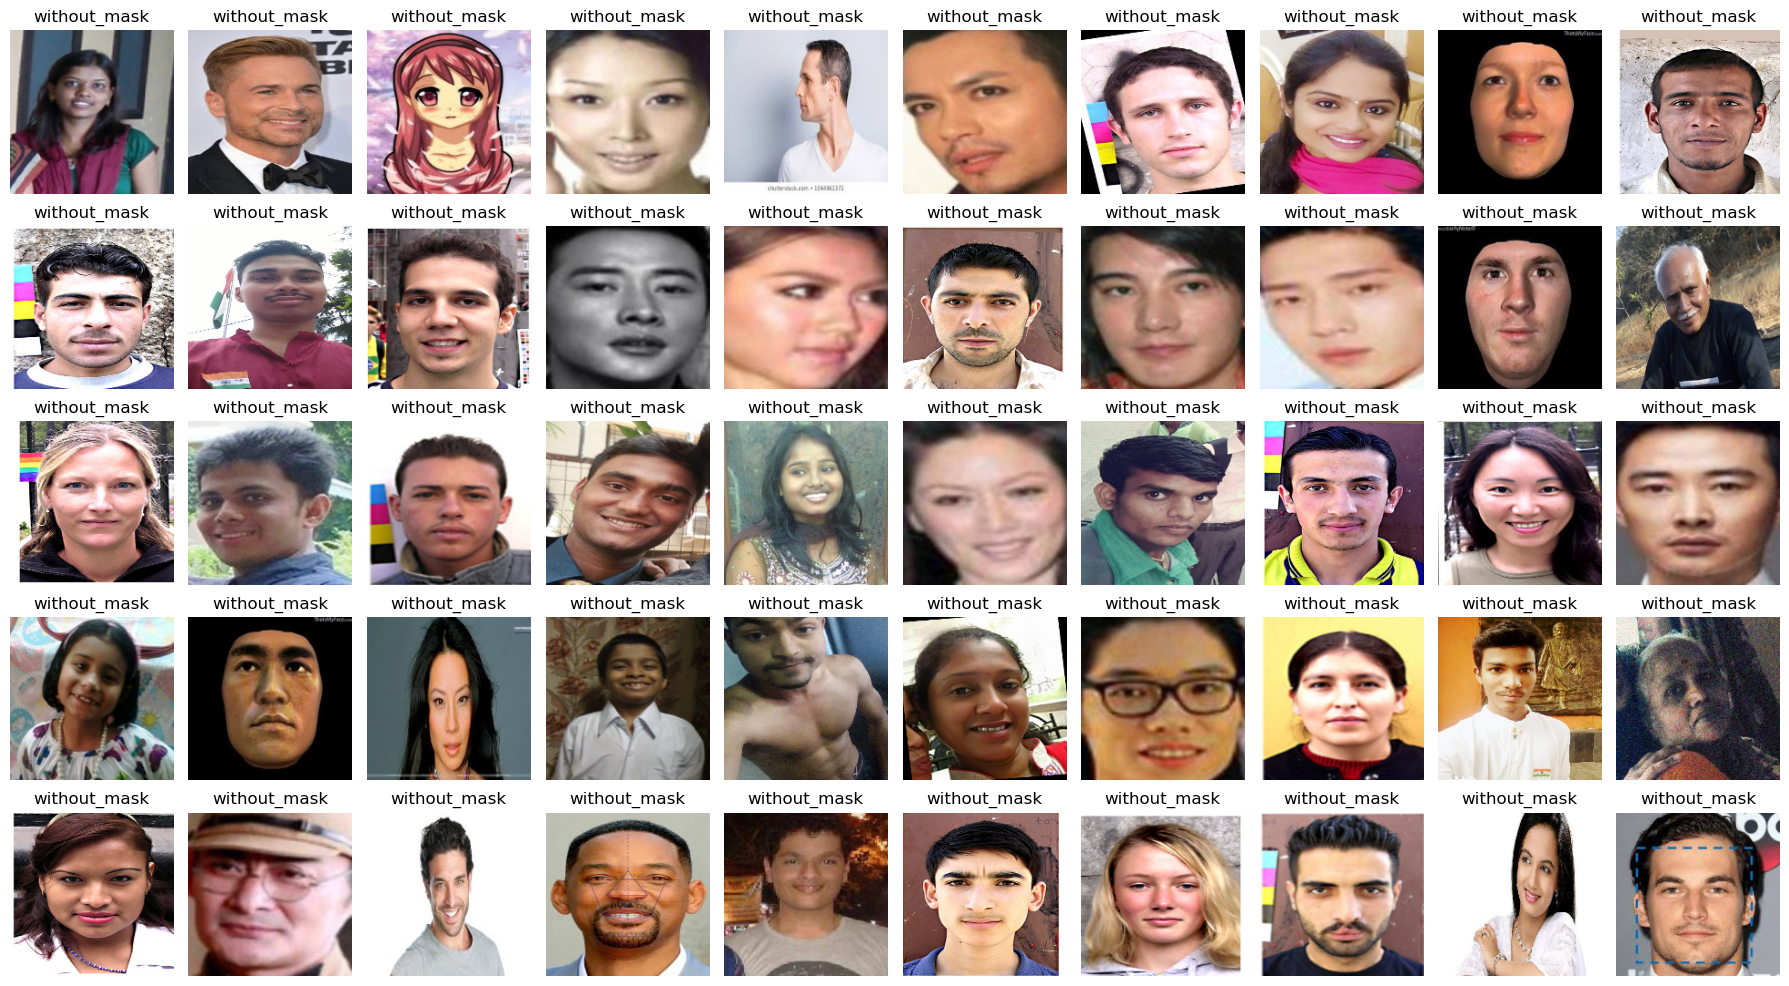

In [10]:
view_images(train_dir, "without_mask", num_images=50, rows=5, cols=10, target_size=180)

In [11]:
import os
import cv2
import random
import numpy as np

train_data = []
train_labels = []

with_mask_dir = os.path.join(train_dir, "with_mask")
without_mask_dir = os.path.join(train_dir, "without_mask")

    
for a in os.listdir(with_mask_dir):
    image = cv2.imread(os.path.join(with_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    train_data.append(image)
    train_labels.append(1)  


for a in os.listdir(without_mask_dir):
    image = cv2.imread(os.path.join(without_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    train_data.append(image)
    train_labels.append(0)  

In [12]:
train_data = np.array(train_data) 
train_labels = np.array(train_labels)

print(f"Train Data Shape\t: {train_data.shape}")
print(f"Train Label Shape\t: {train_labels.shape}")

Train Data Shape	: (2304, 224, 224, 3)
Train Label Shape	: (2304,)


In [13]:
test_data = []
test_labels = []

with_mask_dir = os.path.join(test_dir, "with_mask")
without_mask_dir = os.path.join(test_dir, "without_mask")

for a in os.listdir(with_mask_dir):
    image = cv2.imread(os.path.join(with_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    test_data.append(image)
    test_labels.append(1)  


for a in os.listdir(without_mask_dir):
    image = cv2.imread(os.path.join(without_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    test_data.append(image)
    test_labels.append(0)  

In [14]:
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(f"Test Data Shape \t: {test_data.shape}")
print(f"Test Label Shape\t: {test_labels.shape}")

Test Data Shape 	: (768, 224, 224, 3)
Test Label Shape	: (768,)


In [15]:
val_data = []
val_labels = []

with_mask_dir = os.path.join(test_dir, "with_mask")
without_mask_dir = os.path.join(test_dir, "without_mask")


for a in os.listdir(with_mask_dir):
    image = cv2.imread(os.path.join(with_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    val_data.append(image)
    val_labels.append(1)  


for a in os.listdir(without_mask_dir):
    image = cv2.imread(os.path.join(without_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    val_data.append(image)
    val_labels.append(0)  

In [16]:
val_data = np.array(val_data) 
val_labels = np.array(val_labels)

print(f"Validation Data Shape \t: {val_data.shape}")
print(f"Validation Label Shape\t: {val_labels.shape}")

Validation Data Shape 	: (768, 224, 224, 3)
Validation Label Shape	: (768,)


In [17]:
X_train, y_train = (train_data, train_labels)
X_test, y_test = (test_data, test_labels)
X_val, y_val = (val_data, val_labels)

In [21]:
num_classes = 2  

base_model = tf.keras.applications.MobileNet(
    input_shape = [224,224,3], 
    weights = "imagenet", 
    include_top = False
)

base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=64, activation="relu")(x)

prediction_layer = Dense(units=num_classes, activation="softmax")(x)  

model = Model(inputs=base_model.input, outputs=prediction_layer)

In [22]:
adam_lr = 0.00001
beta1 = 0.99
beta2 = 0.99
eps = 1e-9

optimizer_adam = keras.optimizers.Adam(learning_rate=adam_lr, beta_1=beta1, beta_2=beta2, epsilon=eps)

model.compile(
    optimizer = optimizer_adam, 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [24]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [25]:
h_mobileNet = model.fit(
    X_train, y_train,
    epochs = 10,
    validation_data = (X_val, y_val),
    batch_size = 32
)

Epoch 1/10
72/72 [==============================] - 54s 733ms/step - loss: 0.4392 - accuracy: 0.8312 - val_loss: 0.1989 - val_accuracy: 0.9284
Epoch 2/10
72/72 [==============================] - 51s 709ms/step - loss: 0.1078 - accuracy: 0.9570 - val_loss: 0.1765 - val_accuracy: 0.9375
Epoch 3/10
72/72 [==============================] - 53s 742ms/step - loss: 0.0584 - accuracy: 0.9796 - val_loss: 0.1770 - val_accuracy: 0.9427
Epoch 4/10
72/72 [==============================] - 55s 767ms/step - loss: 0.0290 - accuracy: 0.9939 - val_loss: 0.1389 - val_accuracy: 0.9505
Epoch 5/10
72/72 [==============================] - 52s 728ms/step - loss: 0.0134 - accuracy: 0.9978 - val_loss: 0.1315 - val_accuracy: 0.9570
Epoch 6/10
72/72 [==============================] - 55s 761ms/step - loss: 0.0077 - accuracy: 0.9996 - val_loss: 0.1447 - val_accuracy: 0.9557
Epoch 7/10
72/72 [==============================] - 55s 764ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1661 - val_accuracy: 0.9531

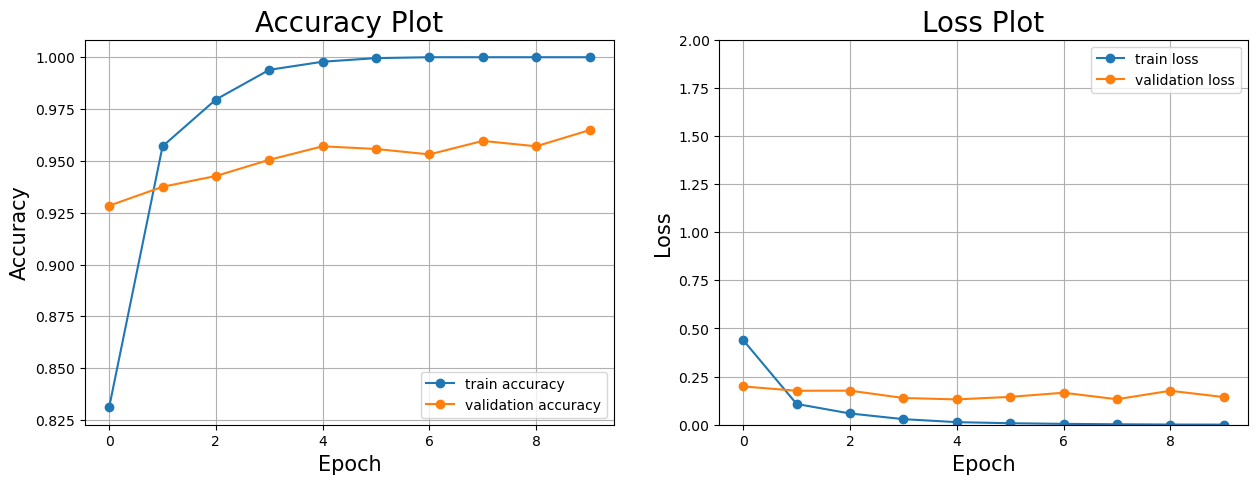

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Accuracy Plot", size=20)
plt.plot(h_mobileNet.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h_mobileNet.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch', size=15)
plt.ylabel('Accuracy', size=15)
plt.grid(True)
plt.legend(loc='lower right')


plt.subplot(1,2,2)
plt.title("Loss Plot", size=20)
plt.plot(h_mobileNet.history['loss'], 'o-', label='train loss')
plt.plot(h_mobileNet.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.ylim([0, 2])
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tabulate import tabulate


predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) 


accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")


confusion = confusion_matrix(y_test, predicted_classes)


confusion_df = pd.DataFrame(
    confusion, index = ["WithoutMask", "WithMask"], 
    columns = ["WithoutMask", "WithMask"]
)


tabulated_confusion = tabulate(confusion_df, headers='keys', tablefmt='pretty')


print("Confusion Matrix:")
print(tabulated_confusion)


class_names = ["WithMask", "WithoutMask"]
report = classification_report(y_test, predicted_classes, target_names=class_names)


print("\nClassification Report:")
print(report)

24/24 [==============================] - 11s 429ms/step
Accuracy: 0.96
Confusion Matrix:
+-------------+-------------+----------+
|             | WithoutMask | WithMask |
+-------------+-------------+----------+
| WithoutMask |     374     |    10    |
|  WithMask   |     17      |   367    |
+-------------+-------------+----------+

Classification Report:
              precision    recall  f1-score   support

    WithMask       0.96      0.97      0.97       384
 WithoutMask       0.97      0.96      0.96       384

    accuracy                           0.96       768
   macro avg       0.96      0.96      0.96       768
weighted avg       0.96      0.96      0.96       768

